In [1]:
import numpy as np
import pandas as pd
import random
import shap
from math import sqrt
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from scipy.stats import sem, t
from scipy import mean

import warnings
warnings.filterwarnings('ignore')

import pickle

In [2]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

In [3]:
#Simulate Genotype
def simulate_genotype(samples_n, loci_m):
    f_M = np.random.uniform(0,1,loci_m)
    G = np.random.binomial(n=2,p = f_M, size = (samples_n,loci_m))
    G = preprocessing.scale(G, axis=0)
    
    assert(len(G) == samples_n)
    assert(len(G[0])== loci_m)
    return G

In [4]:
def simulate_genotype_and_phenotype(samples_n, loci_m,beta_g,e_noise):
    G = simulate_genotype(samples_n, loci_m)
    loci =random.randint(0,loci_m-1)
    SNP = G[:,loci]
    individuals = len(SNP)
    b_i = beta_g
    Y_n = np.zeros((individuals, 1))
    for k in range(0, individuals):
        #each individual will have a e_j(noise) value
        e_j = np.random.normal(0, e_noise)
        #G_ij will be the jth individual from our SNP for the loci of choce
        G_ij  = SNP[k]
        Y_j = b_i*G_ij + e_j
        Y_n[k] = Y_j 
    y_max = np.max(Y_n)
    y_max = abs(y_max)
    Y_n = np.array(Y_n)
    Y_n = Y_n/y_max
    Y_n = Y_n.reshape(samples_n,1)
    G = np.append(G, Y_n, axis=1)
    return G, loci


In [5]:
# def shap_LR_tree_train(G):
#     X = G[:,0:len(G[0])-1]
#     y = G[:,len(G[0])-1]
#     x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
#     linReg = LinearRegression() 
#     linReg.fit(x_train, y_train) 
#     explainer = shap.KernelExplainer(linReg.predict, shap.kmeans(x_train,100))
#     shap_values = explainer.shap_values(x_test)
#     return shap_values

In [6]:
# def shap_LR_tree_train(G):
#     X = G[:,0:len(G[0])-1]
#     y = G[:,len(G[0])-1]
#     x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
#     forReg = RandomForestRegressor(max_depth=20, min_samples_split =5,min_samples_leaf=4,random_state=0, n_estimators=1000)
#     forReg.fit(x_train, y_train)
#     shap_values = shap.TreeExplainer(forReg).shap_values(x_train)
#     return shap_values

In [17]:
def shap_LR_tree_train(G):
    X = G[:,0:len(G[0])-1]
    y = G[:,len(G[0])-1]
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    model = Sequential()
    model.add(Dense(256, activation='relu', input_dim = len(X[0])))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='relu', input_dim = 256))
    model.add(Dropout(0.25))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=10, batch_size=10, verbose = 0)
    explainer = shap.DeepExplainer(model, x_train)
    shap_values = explainer.shap_values(x_test)
    return shap_values

In [18]:
# FOR NNN
def mean_shap_values(shap_values):
    shap_values = np.array(shap_values)
    shap_values2 = np.zeros((len(shap_values[0]),len(shap_values[0][0])))
    shap_values2[:][:] = shap_values[0,:,:]
#     shap_values2 = np.array(shap_values2)
    avg_shap = []
    for i in range(0,len(shap_values2[0])):
        shap2 = np.mean(abs(shap_values2[:,i]))
        avg_shap.append(shap2)
    return avg_shap 

In [19]:
# #for LR
# def mean_shap_values(shap_values):
#     shap_values = np.array(shap_values)
#     avg_shap = []
#     for i in range(0,len(shap_values[0])):
#         shap2 = np.mean(abs(shap_values[:,i]))
#         avg_shap.append(shap2)
#     return avg_shap

In [20]:
def max_mean_feature(shap_values):
    avg_shap = mean_shap_values(shap_values)
    temp1 = np.asarray(avg_shap)
    temp2 = temp1
    indices = temp1.argsort()[-2:][::-1]
    avg_shap_loci1,avg_shap_loci2 = avg_shap[indices[0]],avg_shap[indices[1]]
    return indices[0], avg_shap_loci1,temp2

In [21]:
def is_FP(shap_vals,casual_loci_index,threshold):
    for i in range (0, len(shap_vals)):
        if(i != casual_loci_index and shap_vals[i] >= threshold):
            return True
    return False

In [22]:
def metrics_sum(shap_vals,casual_loci_index,threshold):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range (0, len(shap_vals)):
        #TP
        if(i == casual_loci_index and shap_vals[i] >= threshold):
            TP = TP+1
        #FN
        elif(i == casual_loci_index and shap_vals[i] < threshold):
            FN =  FN+1
        #TN
        elif(i != casual_loci_index and shap_vals[i] < threshold):
            TN = TN+1
        #FP
        elif(i != casual_loci_index and shap_vals[i] >= threshold):
            FP = FP+1
        else:
            a = 1

    return TP,FP,TN,FN

In [23]:
def shap_acc_LR_var(samples_n, loci_m, var_e, number_trials,threshold):
    metrics_list = []
    counter = 0
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    var_g_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    while counter != number_trials:
        var_g = random.choice(var_g_list)
        G, loci = simulate_genotype_and_phenotype(samples_n,loci_m, var_g , var_e)
        shap_values_holder = shap_LR_tree_train(G)
        max_holder = max_mean_feature(shap_values_holder)
        avg_shap = max_holder[2]
#         print(avg_shap)
        metrics = metrics_sum(avg_shap,loci,threshold)
        TP = TP+metrics[0]
        FP = FP+metrics[1]
        TN = TN+metrics[2]
        FN = FN+metrics[3]
        counter += 1
    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)
    return FPR,TPR 

In [24]:
# # var_g_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# var_g_list = [0.1]

# number_trials = 1
# samples = 500
# loci = 20
# metric_lists_total =  []
# shap_threshold = 0.040236
# for var_g in var_g_list:
#     metric_lists_total.append(shap_acc_LR_var(samples, loci,var_g,number_trials,shap_threshold))
        

In [27]:
FPR_List_Total = []
TPR_List_Total = []
threshold_list = [0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,1]
var_e_list  =[0,.2,.4,.6,.8]
number_trials = 100
samples = 1000
loci = 20
# metric_lists_total =  []
FPR_List = []
TPR_List = [] 
for var_e in var_e_list:
    FPR_List = []
    TPR_List = []
    for threshold in threshold_list:
        FPR,TPR = shap_acc_LR_var(samples, loci,var_e,number_trials,threshold)
        FPR_List.append(FPR)
        TPR_List.append(TPR)
    FPR_List_Total.append(FPR_List)
    TPR_List_Total.append(TPR_List) 

In [28]:
with open ('/Users/kevin/Downloads/metrics_SHAP_FPR_NN', 'rb') as fp:
    FPR_List_Total = pickle.load(fp)
with open ('/Users/kevin/Downloads/metrics_SHAP_TPR_NN', 'rb') as fp:
    TPR_List_Total = pickle.load(fp)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/kevin/Downloads/metrics_SHAP_FPR_NN'

In [ ]:
FPR_List_Total[0]

In [ ]:
TPR_List_Total[0]

In [ ]:
# with open ('/Users/kevin/Desktop/UCLA_BIG_Code/Code_Data/LR_metrics_toplot/metrics_LR_varg_1', 'rb') as fp:
#     corr2list = pickle.load(fp)

In [29]:
with open('/Users/kevin/Downloads/metrics_SHAP_FPR_NN', 'wb') as fp:
    pickle.dump(FPR_List_Total, fp)

In [30]:
with open('/Users/kevin/Downloads/metrics_SHAP_TPR_NN', 'wb') as fp:
    pickle.dump(TPR_List_Total, fp)

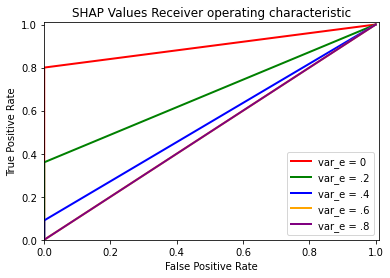

In [35]:
plt.figure()

# Roc Curve:
plt.plot(FPR_List_Total[0], TPR_List_Total[0], color='red', lw=2,
         label='var_e = 0')
plt.plot(FPR_List_Total[1], TPR_List_Total[1], color='green', lw=2,
         label='var_e = .2')
plt.plot(FPR_List_Total[2], TPR_List_Total[2], color='blue', lw=2,
         label='var_e = .4')
plt.plot(FPR_List_Total[3], TPR_List_Total[3], color='orange', lw=2,
         label='var_e = .6')
plt.plot(FPR_List_Total[4], TPR_List_Total[4], color='purple', lw=2,
         label='var_e = .8')
# Random Guess line:
# plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

# Defining The Range of X-Axis and Y-Axis:
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])

# Labels, Title, Legend:
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SHAP Values Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('NN_ROC_Multiple')
plt.show()